In [1]:
import numpy as np
def kmeans_numpy(X, n_clusters, max_iters=100):

    """
    Hint:
    if implementing using numpy array:
    the shape of the centroids are (n_clusters x 2 ), a 2D array--> each cluster is has a coordinate with makes it a 2 value
    The shape of the labels are (for the given sample image) 512 x 512 = 262144 --> a 1D array
    """
    # Initialize cluster centroids randomly
    centroids = X[np.random.choice(len(X), n_clusters, replace=False)]
    labels = np.zeros(X.shape[0])
    for _ in range(max_iters):
        # for i in range(X.shape[0]):
        #     distances = np.linalg.norm(X[i] - centroids, axis=1)
        #     labels[i] = np.argmin(distances)
        
        distances = np.linalg.norm(X[:,np.newaxis]-centroids, axis= 2)
        labels =  np.argmin(distances,axis=1)
        new_centroids = np.zeros((n_clusters, X.shape[1]))

        for k in range(n_clusters):
            cluster_points = X[labels == k]
            
            new_centroids[k] = np.mean(cluster_points, axis=0)
            
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return centroids, labels

In [2]:
def create_compressed_image(labels, centroids, height, width, channels):
    """
    Hint:
    Assign the cluster value to the pixel of that cluster
    """
    # Step 3: Create a compressed image based on cluster centroids
    compressed_image = np.zeros((height, width, channels), dtype=np.uint8)

    label_idx = 0
    for i in range(height):
        for j in range(width):
            cluster_label = labels[label_idx]
            compressed_image[i, j] = centroids[int(cluster_label)]
            label_idx += 1

    return compressed_image

Original image size: 521129 bytes
Compressed image size: 165716 bytes
Compression ratio: 3.14


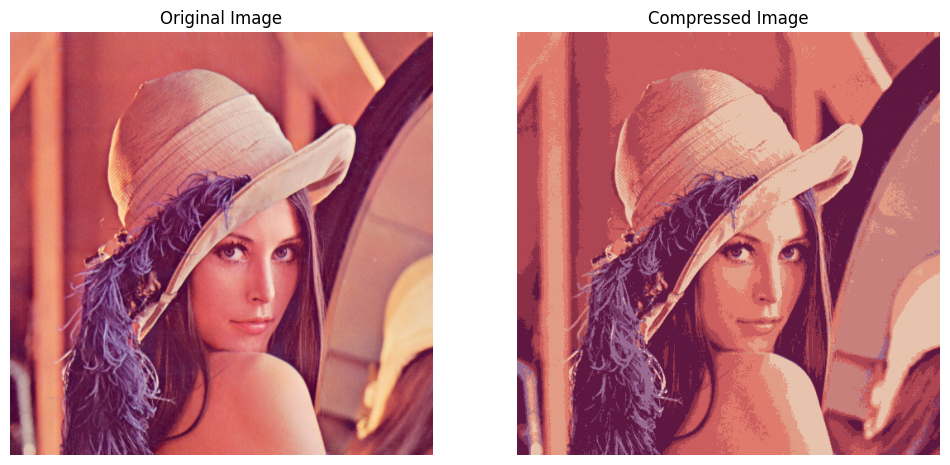

In [3]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def kmeans_image_compression(image_path, num_clusters):
    # Step 1: Load the image
    original_image = cv2.imread(image_path)

    # Convert the image to RGB color space (if it's not already)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Get the dimensions of the image
    height, width, channels = original_image.shape

    # Step 2: Apply K-means clustering using numpy
    pixel_values = original_image.reshape(-1, 3)
    centroids, labels = kmeans_numpy(pixel_values, num_clusters)

    # Step 3: Create a compressed image based on cluster centroids
    compressed_image = create_compressed_image(labels, centroids, height, width, channels)

    # Step 4: Save the compressed image
    compressed_image_path = "compressed_image.png"
    cv2.imwrite(compressed_image_path, cv2.cvtColor(compressed_image, cv2.COLOR_RGB2BGR))

    # Save the original image in the same format as the compressed one
    original_image_path = "original_image.png"
    cv2.imwrite(original_image_path, cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR))

    # Calculate and print the compression ratio
    original_size = os.path.getsize(original_image_path)
    compressed_size = os.path.getsize(compressed_image_path)
    compression_ratio = original_size / compressed_size

    print(f"Original image size: {original_size} bytes")
    print(f"Compressed image size: {compressed_size} bytes")
    print(f"Compression ratio: {compression_ratio:.2f}")

    # Show the original and compressed images using matplotlib
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(compressed_image)
    plt.title("Compressed Image")
    plt.axis("off")

    plt.show()

if __name__ == "__main__":
    image_path = "test_image.png"

    num_clusters = 10  # Adjust the number of clusters as needed
    kmeans_image_compression(image_path, num_clusters)
